# see what angles get reconstructed well

In [1]:
import jkutils
import os, sys
import numpy as np
import scipy.stats as stats
from keras.models import load_model
import math
import shelve
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

Using Theano backend.
/home/jkager/.local/lib/python2.7/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


# analyze test_results

In [2]:
#charge
today = '2017-08-24'
project_name = 'charge_h012_v1'

In [3]:
#time
today = '2017-08-24'
project_name = 'time_h012_v1'

In [4]:
file_location = '/data/user/jkager/NN_Reco/johannes/updownclassification_3/'
data_location = '/data/user/jkager/NN_Reco/training_data_20x10x60/'
test_results = 'test_results.npy'

project_folder = 'train_hist/{}/{}'.format(today, project_name)
print "looking for", project_folder
if not os.path.exists(os.path.join(file_location,project_folder)):
    print "project not found. exiting..."
    sys.exit(-1)
elif not os.path.exists(os.path.join(file_location, project_folder, test_results)):
    print "test results not found. exiting..."
    sys.exit(-1)
print "found"
shelf = shelve.open(os.path.join(file_location, project_folder, 'run_info.shlf'))
input_files = shelf['Files'].split(':')
if len(input_files) == 1: #this could be something like ['h01'] (inputformat)
    #try to decode fileinput format
    input_files = jkutils.get_filenames(input_files[0])
    for f in input_files:
        if not os.path.isfile(os.path.join(data_location, 'training_data/{}'.format(f))):
            print "file not found:", f
            print "exiting script."
            sys.exit(1)
train_inds = shelf['Train_Inds'] 
valid_inds = shelf['Valid_Inds']
test_inds = shelf['Test_Inds']
test_results = np.load(os.path.join(file_location, project_folder, test_results))
input_data, out_data, file_len = jkutils.read_files(input_files, data_location, using=shelf['using'])

looking for train_hist/2017-08-24/time_h012_v1
found


res is the output value of the network. test_out is the expected value (0 or 1, up or down depending on the real zenith value). zenith_out is the real zenith value

In [5]:
res, test_out, zenith_out = test_results[0,:], test_results[1,:], test_results[2,:] #network output (0 or 1), 
                                                                                    #desired output (0 or 1),
                                                                                    #zenith (0 to pi)

In [11]:
len(res)

125336

In [6]:
bins = 20*18+1
x_hist = np.linspace(0,math.pi,bins)
y_hist = np.zeros((bins-1))
cor, summe = 0, 0
for i in range(len(x_hist)-1):
    indizes = np.bitwise_and(zenith_out >= x_hist[i], zenith_out < x_hist[i+1])
    correct = np.sum(np.round(res[indizes]) == jkutils.zenith_to_binary(zenith_out[indizes]))
    print correct, np.sum(indizes), x_hist[i] * 180/math.pi
    cor += correct
    summe += np.sum(indizes)
    y_hist[i] = float(correct)/np.sum(indizes)
print cor / float(summe)

4 5 0.0
8 9 0.5
16 16 1.0
24 25 1.5
19 24 2.0
28 32 2.5
44 50 3.0
48 53 3.5
59 63 4.0
61 70 4.5
71 76 5.0
69 74 5.5
88 94 6.0
89 94 6.5
102 111 7.0
106 114 7.5
91 101 8.0
117 126 8.5
117 124 9.0
106 111 9.5
127 139 10.0
126 141 10.5
118 125 11.0
126 135 11.5
145 153 12.0
131 141 12.5
141 157 13.0
114 130 13.5
132 141 14.0
148 160 14.5
149 158 15.0
161 173 15.5
151 163 16.0
151 173 16.5
165 177 17.0
156 180 17.5
182 195 18.0
182 212 18.5
162 181 19.0
157 175 19.5
175 188 20.0
189 205 20.5
185 205 21.0
206 216 21.5
192 213 22.0
193 221 22.5
184 192 23.0
189 210 23.5
190 221 24.0
220 245 24.5
183 221 25.0
184 201 25.5
170 189 26.0
216 245 26.5
208 235 27.0
204 218 27.5
186 205 28.0
205 225 28.5
232 255 29.0
205 234 29.5
198 229 30.0
210 246 30.5
212 232 31.0
202 236 31.5
227 267 32.0
210 226 32.5
208 231 33.0
224 252 33.5
228 250 34.0
215 246 34.5
203 224 35.0
243 271 35.5
230 261 36.0
229 257 36.5
250 276 37.0
249 269 37.5
243 270 38.0
231 261 38.5
238 272 39.0
280 309 39.5
234 249 40.0


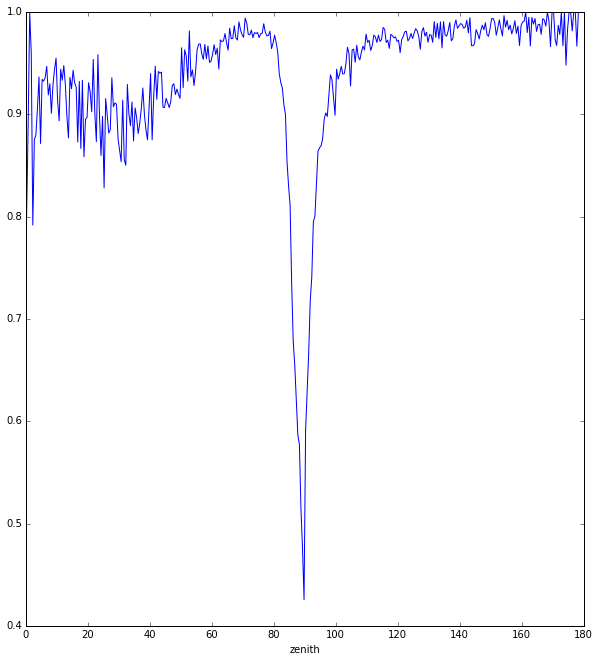

In [10]:
plt.figure(figsize=(10,11))
plt.plot(180/math.pi*(x_hist[:-1]+math.pi/(bins-1)/2),y_hist)
plt.xlabel('zenith')
plt.show()

In [8]:
true_pos, true_neg = 0, 0
false_pos, false_neg = 0, 0
reals, preds = [], []
for pred, real in zip(res, test_out):
    if real == 1:
        if pred < 0.5:
            false_neg += 1
        else:
            true_pos += 1
    if real == 0:
        if pred > 0.5:
            false_pos += 1
        else:
            true_neg += 1
    reals.append(real)
    preds.append(pred)

In [9]:
print "         |    pos    |    neg    "
print "---------+-----------+-----------"
sum_all = true_pos + false_pos + true_neg + false_neg
if sum_all == 0:
    print "no data"
print "test pos |{:10.2f}%|{:10.2f}%".format(100 * true_pos / float(sum_all), 100 * false_pos / float(sum_all))
print "test neg |{:10.2f}%|{:10.2f}%".format(100 * false_neg / float(sum_all), 100 * true_neg / float(sum_all))


print "---------+-----------+-----------\n"*2,    
print "         |    pos    |    neg    "
print "---------+-----------+-----------" 
print "test pos |{:11.0f}|{:11.0f}".format(100 * true_pos, 100 * false_pos)
print "test neg |{:11.0f}|{:11.0f}".format(100 * false_neg, 100 * true_neg)

         |    pos    |    neg    
---------+-----------+-----------
test pos |     51.25%|      4.44%
test neg |      2.82%|     41.49%
---------+-----------+-----------
---------+-----------+-----------
         |    pos    |    neg    
---------+-----------+-----------
test pos |    6423500|     556100
test neg |     353700|    5200300


In [11]:
print "\n".join(map(str, zip(reals, preds))[:200])

(1.0, 0.9986264705657959)
(1.0, 0.16152086853981018)
(0.0, 0.00034043632331304252)
(1.0, 0.99805128574371338)
(1.0, 0.99730503559112549)
(1.0, 0.99995172023773193)
(1.0, 0.99906235933303833)
(1.0, 0.99985742568969727)
(0.0, 1.0549966646067332e-05)
(1.0, 0.97882163524627686)
(1.0, 0.18986433744430542)
(1.0, 0.95469653606414795)
(0.0, 0.0014480318641290069)
(1.0, 0.31810095906257629)
(1.0, 0.99770206212997437)
(0.0, 0.19017940759658813)
(1.0, 0.99577635526657104)
(0.0, 0.003799935569986701)
(1.0, 0.99764388799667358)
(1.0, 0.98945504426956177)
(1.0, 0.99902582168579102)
(1.0, 0.9982638955116272)
(1.0, 0.99820089340209961)
(0.0, 0.0076321708038449287)
(1.0, 0.9993627667427063)
(1.0, 0.97248071432113647)
(1.0, 0.99826329946517944)
(0.0, 0.0073660095222294331)
(1.0, 0.89859479665756226)
(0.0, 0.01819021999835968)
(1.0, 0.99906164407730103)
(1.0, 0.98411464691162109)
(0.0, 0.31598615646362305)
(1.0, 0.75635993480682373)
(0.0, 0.005715253297239542)
(0.0, 0.15248973667621613)
(1.0, 0.999982476

##now with filtering by number of hit doms

In [6]:
def num_hit_bins(input_set):
    ret = 0
    for i in input_set.flatten():
        if i != np.inf:
            ret += 1
    return ret

In [7]:
def get_pos_in_res(i_file, i_in_testsets):
    before = sum([test_inds[i][1] - test_inds[i][0] for i in range(i_file)])
    return before + i_in_testsets

In [11]:
ntestsets = sum([test_inds[i][1] - test_inds[i][0] for i in range(len(input_data))])

In [12]:
nhits=np.zeros((ntestsets))
for file_n in range(len(input_data)):
    for i, inp_s in enumerate(input_data[file_n][test_inds[file_n][0]:test_inds[file_n][1]]):
        nhits[get_pos_in_res(file_n, i)] = num_hit_bins(inp_s)
        #nhits[file_n*100+ i] = num_hit_bins(inp_s)

In [67]:
stats.describe(nhits)

DescribeResult(nobs=125336, minmax=(21.0, 1262.0), mean=264.58187591753369, variance=47554.688377463084, skewness=1.1102390173559675, kurtosis=0.6409461624092767)

In [10]:
num_hit_bins(input_data[0][test_inds[0][0]])

225

In [13]:
np.save("save_ndoms_h012_testsets",nhits)

In [16]:
nhits

array([ 225.,  428.,  649., ...,   89.,  432.,   82.])

## accuracy over number of hit bins

In [27]:
def num_hit_bins(input_set):
    ret = 0
    for i in input_set.flatten():
        if i is not np.inf:
            ret += 1
    return ret

In [54]:
def get_pos_in_res(i_file, i_in_testsets):
    before = sum([test_inds[i][1] - test_inds[i][0] for i in range(i_file)])
    return before + i_in_testsets

In [ ]:
bins = 100
input_shape = input_data[0].shape[1:-1]
x_bins = np.linspace(0,reduce(lambda x, y: x*y, input_shape),bins)
y_acc = [[] for i in range(splits-1)]
cor, summe = 0, 0
for file_n in range(len(input_data)):
    for i, inp_s in enumerate(input_data[file_n][test_inds[file_n][0]:test_inds[file_n][1]]):
        n_hit = num_hit_bins(inp_s)
        bin_n = np.digitize(np.array([n_hit]), x_bins)[0]
        #remember if it was correctly reconstructed
        index = get_pos_in_res(file_n, i)
        correct = np.round(res[index]) == jkutils.zenith_to_binary(zenith_out[index]) #latter is same as tet_out
        y_acc[file_n].append(correct)
y_acc = [float(sum(i))/len(i) for i in y_acc]

In [ ]:
plt.figure()
plt.plot(x_bins[:-1]+float(x_bins[-1]-x_bins[0])/(len(x_bins)-1)/2, y_acc)
plt.xlabel('zenith')
plt.show()

In [23]:
input_data[0]

<HDF5 dataset "time": shape (207254, 20, 10, 60, 1), type "<f8">

In [26]:
input_data[0][0].flatten()[0] == np.inf

True

In [35]:
x_bins

array([     0.        ,    121.21212121,    242.42424242,    363.63636364,
          484.84848485,    606.06060606,    727.27272727,    848.48484848,
          969.6969697 ,   1090.90909091,   1212.12121212,   1333.33333333,
         1454.54545455,   1575.75757576,   1696.96969697,   1818.18181818,
         1939.39393939,   2060.60606061,   2181.81818182,   2303.03030303,
         2424.24242424,   2545.45454545,   2666.66666667,   2787.87878788,
         2909.09090909,   3030.3030303 ,   3151.51515152,   3272.72727273,
         3393.93939394,   3515.15151515,   3636.36363636,   3757.57575758,
         3878.78787879,   4000.        ,   4121.21212121,   4242.42424242,
         4363.63636364,   4484.84848485,   4606.06060606,   4727.27272727,
         4848.48484848,   4969.6969697 ,   5090.90909091,   5212.12121212,
         5333.33333333,   5454.54545455,   5575.75757576,   5696.96969697,
         5818.18181818,   5939.39393939,   6060.60606061,   6181.81818182,
         6303.03030303,  